In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import matplotlib.patches as patches
import keras_tuner as kt
import seaborn as sns
import tensorflow as tf
import random

from skimage.feature import SIFT, match_descriptors, daisy
from skimage.color import rgb2gray
from skimage.io import imread
from skimage.color import rgb2gray
from skimage import exposure
from skimage import color
from skimage.feature import SIFT
from skimage.filters import threshold_otsu
from skimage.filters import threshold_local
from skimage.morphology import binary_erosion
from skimage.measure import regionprops, find_contours

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical, load_img, img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn import svm
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from scipy.stats import randint

import warnings
warnings.filterwarnings('ignore')


# Load and Preprocess Data

In [2]:
# Load the image paths and labels from the DataFrame
df = pd.read_csv('Dataset/cards.csv')

# For column names that contain space, replace the space with an underscore
df.columns = [c.replace(' ', '_') for c in df.columns]

# Add suits column
df['suit'] = df['labels'].str.split().str[-1]

# Remove rows with jokers
df = df[~df['suit'].str.contains('joker', case=False)]

# Remove unwanted columns
df = df.drop(columns = ['data_set'])
df = df.drop(columns = ['class_index'])
df = df.drop(columns = ['labels'])
df = df.drop(columns = ['card_type'])

# Add folder name to the filepath
df['filepaths'] = df['filepaths'].apply(lambda x: 'Dataset/' + x)
df.head()

,filepaths,suit
0,Dataset/train/ace of clubs/001.jpg,clubs
1,Dataset/train/ace of clubs/002.jpg,clubs
2,Dataset/train/ace of clubs/003.jpg,clubs
3,Dataset/train/ace of clubs/004.jpg,clubs
4,Dataset/train/ace of clubs/005.jpg,clubs


In [3]:
# Split dataframe into train and test sets, stratified by the 'suit' column
train_df, test_df = train_test_split(df, test_size=0.2, stratify=df['suit'], random_state=42)

# Split train set into train and validation sets, stratified by the 'suit' column
train_df, val_df = train_test_split(train_df, test_size=0.2, stratify=train_df['suit'], random_state=42)

# Check class distribution in the train, validation, and test sets
train_class_distribution = train_df['suit'].value_counts(normalize=True)
val_class_distribution = val_df['suit'].value_counts(normalize=True)
test_class_distribution = test_df['suit'].value_counts(normalize=True)

print("Train Set - Class Distribution:")
print(train_class_distribution)

print("Validation Set - Class Distribution:")
print(val_class_distribution)

print("Test Set - Class Distribution:")
print(test_class_distribution)

Train Set - Class Distribution:
spades      0.269171
hearts      0.246010
diamonds    0.243675
clubs       0.241144
Name: suit, dtype: float64
Validation Set - Class Distribution:
spades      0.269261
hearts      0.245914
diamonds    0.243580
clubs       0.241245
Name: suit, dtype: float64
Test Set - Class Distribution:
spades      0.268991
hearts      0.245953
diamonds    0.244085
clubs       0.240971
Name: suit, dtype: float64


In [4]:
train_df.head()

,filepaths,suit
2253,Dataset/train/four of spades/062.jpg,spades
4829,Dataset/train/seven of clubs/008.jpg,clubs
1631,Dataset/train/five of spades/023.jpg,spades
3638,Dataset/train/king of spades/133.jpg,spades
6634,Dataset/train/three of clubs/118.jpg,clubs


In [5]:
# Detect and Extract Keypoints Features and Descriptors
def detect_and_extract_keypoints(dataframe):
    dataframe = dataframe.reset_index(drop = True)
    
    #initialise SIFT
    detector_and_extractor = SIFT(upsampling=2, 
                              n_octaves=10, 
                              n_scales=10, 
                              sigma_min=1.8, 
                              sigma_in=0.5, 
                              c_dog=0.01, 
                              c_edge=30, 
                              n_bins=36, 
                              lambda_ori=1.5, 
                              c_max=0.8, 
                              lambda_descr=6, 
                              n_hist=4, 
                              n_ori=8
                             )
    keypoint_images = []
    keypoint_labels = []
    keypoint_descript = []
    keypoint_feat = []
    keypoint_pixels = []

    # For each image in the dataset, detect and extract the key features and key descriptors
    for i in range(len(dataframe)):
        rgb_test_image = cv2.imread(dataframe['filepaths'][i])
        gray_test_image = rgb2gray(rgb_test_image)
        normalised_image = cv2.normalize(gray_test_image, 
                                            None, 
                                            alpha=0, 
                                            beta=1, 
                                            norm_type=cv2.NORM_MINMAX
                                           )

        detector_and_extractor.detect_and_extract(normalised_image)
        keypoint_features = detector_and_extractor.keypoints
        keypoint_descriptors = detector_and_extractor.descriptors

        # Extract the pixels associated with the key feature coordinates
        if len(keypoint_features) > 0:
            keypoint_feature_image = np.zeros(gray_test_image.shape)
            key_pixels = []

            for point in keypoint_features:
                keypoint_feature_image[point[0], point[1]] = gray_test_image[point[0], point[1]]
                key_pixel = gray_test_image[point[0], point[1]]
                key_pixels.append(key_pixel)
            
            # a count since this process takes a really long time, it tells me how far along it has reached
            if i % 1000 == 0:
                print(i)
            keypoint_pixels.append(key_pixels)
            keypoint_images.append(keypoint_feature_image)
            keypoint_labels.append(dataframe['suit'][i])
            keypoint_descript.append(keypoint_descriptors)
            keypoint_feat.append(keypoint_features)
    
    #return the images, the labels, the descriptors, the feature coordinates and the key pixels
    return keypoint_images, keypoint_labels, keypoint_descript, keypoint_feat, keypoint_pixels


# Function to encode the labels 
def encode_labels(labels):
    label_encoder = preprocessing.LabelEncoder()
    keypoint_labels_encoded = label_encoder.fit(labels)
    encoded_labels_transformed = label_encoder.transform(labels)
    
    return encoded_labels_transformed


# Function to flatten the descriptor arrays
def flatten_images(image_dataset):
    flattened_images = []

    for image in image_dataset:
        flat_image = np.ravel(image)
        flat_image = flat_image/255
        flattened_images.append(flat_image)
        
    return np.array(flattened_images)


# Function to slice the feature and descriptor vectors to the same lengths
def slice_vectors(rep_vector, descriptor_vector, pixel_vector):
    length_feature_vectors = [len(feature) for feature in rep_vector]
    min_len = np.min(length_feature_vectors)

    sliced_feature_vector = np.array([feat_vec[:min_len] for feat_vec in pixel_vector])
    sliced_descriptor_vector = np.array([feat_vec[:min_len] for feat_vec in descriptor_vector])
    
    return sliced_feature_vector, sliced_descriptor_vector

In [6]:
# Extract Features, Descriptors and Pixels
train_image, train_label, train_kp_descriptors, train_kp_features, train_kp_pixels = detect_and_extract_keypoints(train_df)
val_image, val_label, val_kp_descriptors, val_kp_features, val_kp_pixels = detect_and_extract_keypoints(val_df)
test_image, test_label, test_kp_descriptors, test_kp_features, test_kp_pixels = detect_and_extract_keypoints(test_df)

# Creates the sliced vectors
train_pixel_vecs, train_descriptors_vecs = slice_vectors(train_kp_features, train_kp_descriptors, train_kp_pixels)
valid_pixel_vecs, valid_descriptors_vecs = slice_vectors(train_kp_features, val_kp_descriptors, val_kp_pixels)
test_pixel_vecs, test_descriptors_vecs   = slice_vectors(train_kp_features, test_kp_descriptors, test_kp_pixels)

# Flatten the descriptors into one descriptor feature vector per image
train_flat_descriptors = flatten_images(train_descriptors_vecs)
val_flat_descriptors = flatten_images(valid_descriptors_vecs)
test_flat_descriptors = flatten_images(test_descriptors_vecs)

# Create the Feature vector which is a combination of the key pixels and the HoG of each keypoint feature
flattened_train_images = np.hstack((train_flat_descriptors, train_pixel_vecs))
flattened_validation_images = np.hstack((val_flat_descriptors, valid_pixel_vecs))
flattened_test_images = np.hstack((test_flat_descriptors, test_pixel_vecs))

# Encode the laebls
encoded_train_labels = encode_labels(train_label)
encoded_valid_labels = encode_labels(val_label)
encoded_test_labels = encode_labels(test_label)

0
1000
2000
3000
4000
5000
0
1000
0
1000


In [7]:
# Print the lengths of the images and labels
print(f'train image and label vector length: {len(encoded_train_labels)}, {len(flattened_train_images)}')
print(f'validation image and label vector length: {len(encoded_valid_labels)}, {len(flattened_validation_images)}')
print(f'validation image and label vector length: {len(encoded_test_labels)}, {len(flattened_test_images)}')

train image and label vector length: 5138, 5138
validation image and label vector length: 1285, 1285
validation image and label vector length: 1606, 1606


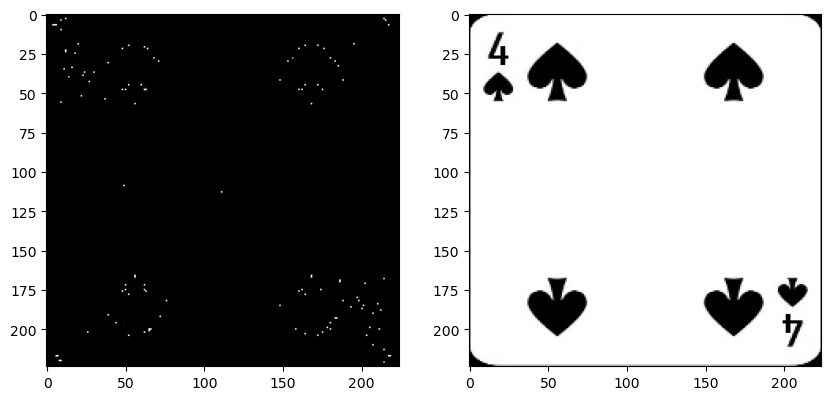

In [8]:
# Visualisation of the identified keypoints
train_image_test = cv2.imread(train_df['filepaths'][2253])
figs, axes = plt.subplots(1,2, figsize=(10,5))
axes[0].imshow(train_image[0], cmap = 'gray')
axes[1].imshow(train_image_test, cmap = 'gray')

# Principal Component Analysis

In [9]:
features_df = pd.DataFrame(flattened_train_images)
features_df.insert(loc = 0, column = 'suit_label', value = encoded_train_labels)
features_df.to_csv('kpf_features.csv')

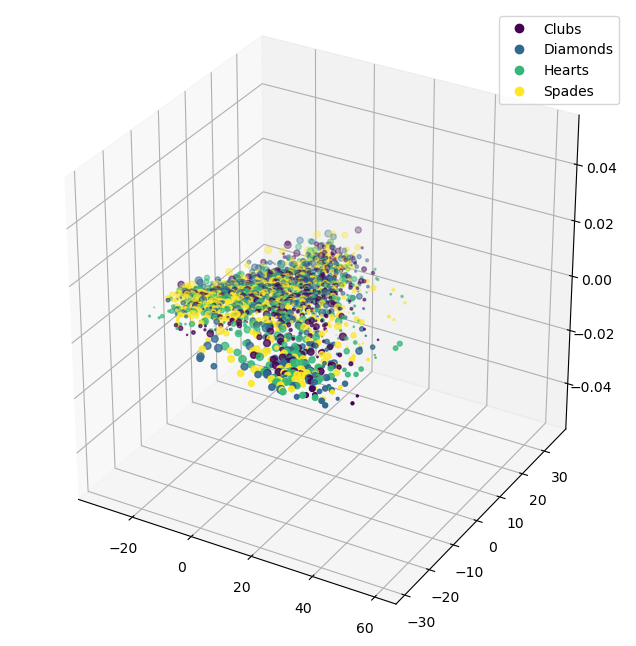

In [10]:
#PCA Plots for first 3 features
features = features_df.iloc[:, 1:]
labels = features_df.iloc[:, 0]
X_features = StandardScaler().fit_transform(features)
pca_calc = PCA(n_components = 3)
X_features_pca = pca_calc.fit_transform(X_features)

#display the 3d PCA plot
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(projection='3d')
ax.set_box_aspect(aspect=(1, 1, 1))
plot = plt.scatter(X_features_pca[:,0], X_features_pca[:,1], X_features_pca[:,2], c=labels)
plt.legend(handles=plot.legend_elements()[0], labels=['Clubs','Diamonds','Hearts','Spades'])
plt.show()

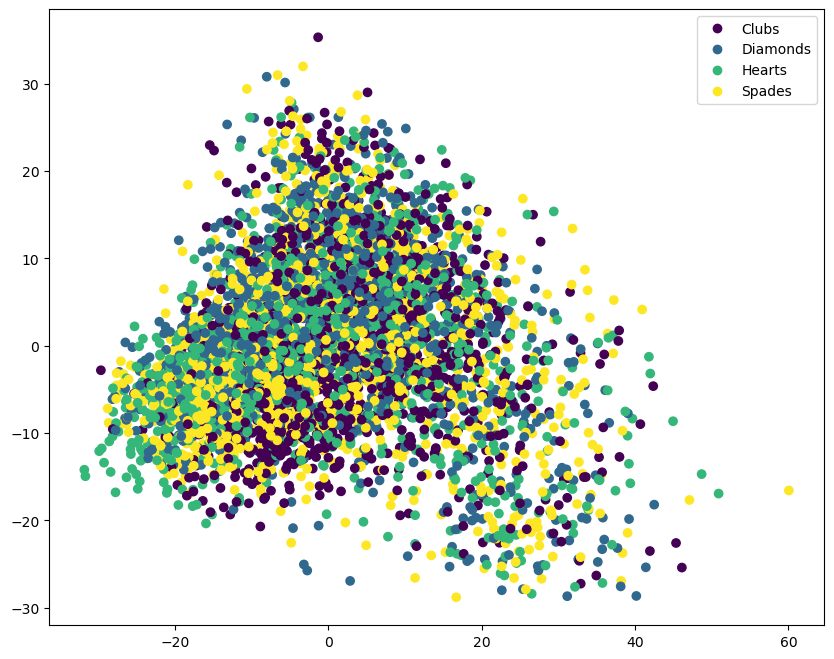

In [11]:
#display 2d PCA plot
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot()
plot = plt.scatter(X_features_pca[:,0], X_features_pca[:,1], c=labels)
plt.legend(handles=plot.legend_elements()[0], labels=['Clubs','Diamonds','Hearts','Spades'])
plt.show()

In [12]:
pca = PCA()
keypoints_features = pca.fit_transform(X_features)

kp_explained_variance = pca.explained_variance_ratio_
kp_cumulative_explained_variance = np.cumsum(kp_explained_variance)

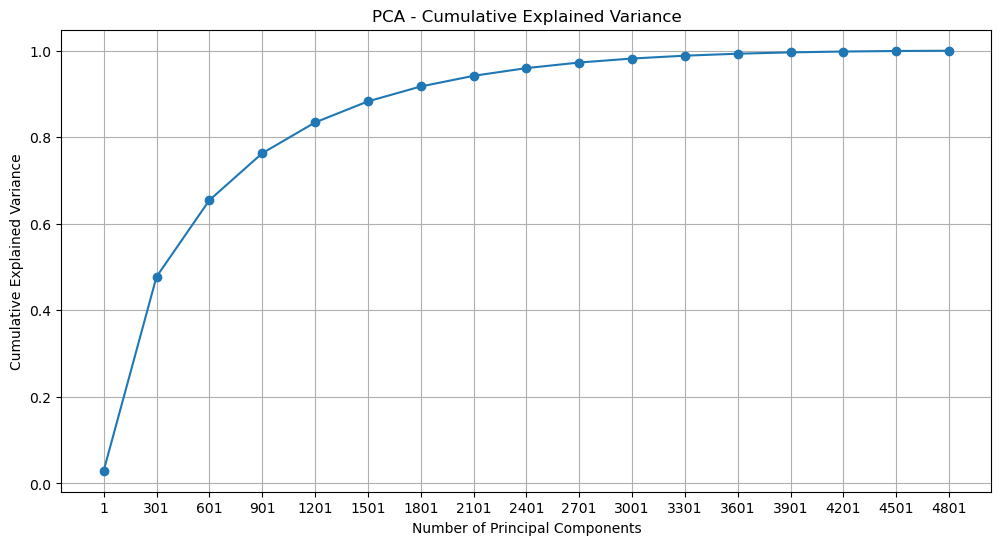

In [13]:
components_range = np.arange(1, 5100, 300)

plt.figure(figsize=(12, 6))
plt.plot(components_range, kp_cumulative_explained_variance[components_range - 1], marker='o')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA - Cumulative Explained Variance')
plt.xticks(components_range)
plt.grid(True)
plt.show()

# Model Analysis
Analysis of Keypoint Features and Descriptors using the following classifiers
- Support Vector Machine
- Linear Discriminant Analysis
- Logistic Regression
- Random Forest
- Neural Network

## 1. SVM Classification on Keypoint Features and Detectors

### 1.1 Hyperparameter tuning of SVM

In [14]:
# SVM HYPERPARAMETER TUNING

svm_param_grid = {'svc__C': [ 1.0, 2.0, 3.0, 4.0], 
              'svc__gamma': ['scale', 'auto', 1.1, 0.1, 0.01],
              'svc__kernel': ['rbf']} 

# SVM Classifier pipline  
svm_pipe = Pipeline([
    ('standardscaler', StandardScaler()),
    ('svc', svm.SVC())
])

# Performing Hyperparameter tuning using GridSearchCV
svm_grid_search = GridSearchCV(svm_pipe, svm_param_grid, cv = 5)
svm_grid_search.fit(flattened_train_images, encoded_train_labels)

# Printing the results of the hyperparameter tuning
print(f'Best parameters: {svm_grid_search.best_score_:0.3f}')
print(svm_grid_search.best_params_)

Best parameters: 0.504
{'svc__C': 3.0, 'svc__gamma': 'scale', 'svc__kernel': 'rbf'}


### 1.2 Selecting the Best Hyperparamaters for the SVM

In [15]:
svm_best_params = svm_grid_search.best_estimator_

### 1.3 Scoring and Analysis of Validation Dataset using SVM Classifier

Validation accuracy score: 0.5183
Validation Classification Report:
               precision    recall  f1-score   support

       clubs       0.54      0.52      0.53       310
    diamonds       0.51      0.50      0.50       313
      hearts       0.56      0.50      0.53       316
      spades       0.48      0.55      0.51       346

    accuracy                           0.52      1285
   macro avg       0.52      0.52      0.52      1285
weighted avg       0.52      0.52      0.52      1285



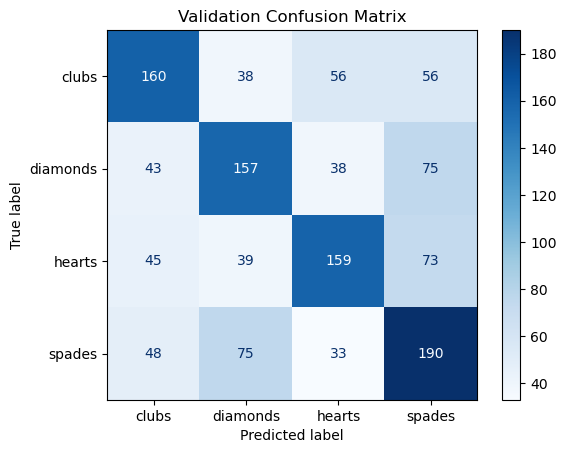

In [16]:
# Calculating the average accuracy for validation dataset
svm_valid_score = svm_best_params.score(flattened_validation_images, encoded_valid_labels)

# Predicting labels of validation data
svm_valid_predict = svm_best_params.predict(flattened_validation_images)


# ------------------ Accuracy Reporting --------------------

# Print Validation Accuracy Score
print(f'Validation accuracy score: {svm_valid_score:.4f}')


# ----------------- Classification Report ------------------

class_names = ['clubs', 'diamonds', 'hearts', 'spades']

# Calculate classification report for validation set
svm_valid_report = classification_report(encoded_valid_labels, svm_valid_predict, target_names=class_names)
print("Validation Classification Report:\n", svm_valid_report)


# ------------------ Confusion Matrix ----------------------

# Generating the confusion matrix
svm_val_confusion_matrix = confusion_matrix(encoded_valid_labels, svm_valid_predict)

# Displaying the confustion matrix
svm_val_display_matrix = ConfusionMatrixDisplay(confusion_matrix = svm_val_confusion_matrix,
                                            display_labels = class_names)

# Display Confusion Matrix
svm_val_display_matrix.plot(cmap=plt.cm.Blues)
svm_val_display_matrix.ax_.set_title('Validation Confusion Matrix')
plt.show()


### 1.4 Scoring and Analysis of Test Dataset using SVM Classifier

Test accuracy score: 0.5093
Test Classification Report:
               precision    recall  f1-score   support

       clubs       0.48      0.51      0.50       387
    diamonds       0.50      0.50      0.50       392
      hearts       0.53      0.51      0.52       395
      spades       0.52      0.52      0.52       432

    accuracy                           0.51      1606
   macro avg       0.51      0.51      0.51      1606
weighted avg       0.51      0.51      0.51      1606



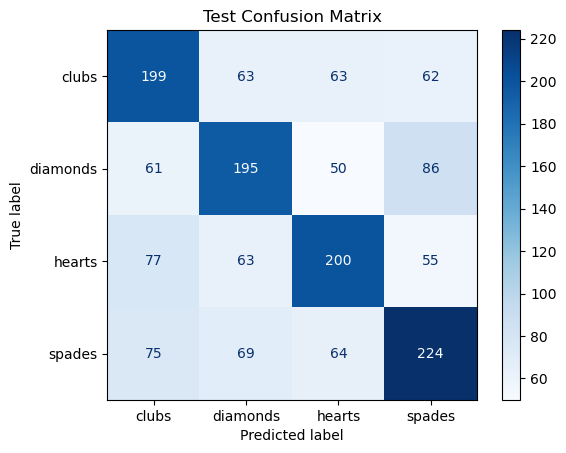

In [17]:
# Calculating the average accuracy score for the test dataset
svm_test_score = svm_best_params.score(flattened_test_images, encoded_test_labels)

# Predicting labels of test data
svm_test_predict = svm_best_params.predict(flattened_test_images)


# ------------------ Accuracy Reporting --------------------

# Print Test Accuracy Score
print(f'Test accuracy score: {svm_test_score:.4f}')


# ----------------- Classification Report ------------------

# Get the class names from the generator (assuming it has the 'class_indices' attribute)

# Calculate classification report for test set
svm_test_report = classification_report(encoded_test_labels, svm_test_predict, target_names = class_names)
print("Test Classification Report:\n", svm_test_report)


# ------------------ Confusion Matrix ----------------------

# Generating the confusion matrix
svm_test_confusion_matrix = confusion_matrix(encoded_test_labels, svm_test_predict)

# Displaying the confustion matrix
svm_test_display_matrix = ConfusionMatrixDisplay(confusion_matrix = svm_test_confusion_matrix,
                                             display_labels = class_names)
# Display Confusion Matrix
svm_test_display_matrix.plot(cmap = plt.cm.Blues)
svm_test_display_matrix.ax_.set_title('Test Confusion Matrix')
plt.show()


## 2. Linear Discriminant Analysis on Keypoint Features and Descriptors

### 2.1 Hyperparameter tuning of the LDA

In [18]:
# HyperParameter Tuning

lda_param_grid = {'lda__solver': ['svd'], 
              'lda__n_components': [1,2,3,4]} 

lda_pipe = Pipeline([
    ('standardscaler', StandardScaler()),
    ('lda', LinearDiscriminantAnalysis())
])

lda_grid_search = GridSearchCV(lda_pipe, lda_param_grid, cv = 5)
lda_grid_search.fit(flattened_train_images, encoded_train_labels)

print("Best parameter (CV score=%0.3f):" % lda_grid_search.best_score_)
print(lda_grid_search.best_params_)

Best parameter (CV score=0.371):
{'lda__n_components': 1, 'lda__solver': 'svd'}


### 2.2 Selecting the Best Estimater Hyperparamaters for LDA

In [19]:
lda_best_params = lda_grid_search.best_estimator_

### 2.3 Scoring and Analysis of Validation Dataset using LDA Classifier

Validation accuracy score: 0.3603
Validation Classification Report:
               precision    recall  f1-score   support

       clubs       0.38      0.35      0.36       310
    diamonds       0.35      0.38      0.36       313
      hearts       0.36      0.35      0.36       316
      spades       0.36      0.36      0.36       346

    accuracy                           0.36      1285
   macro avg       0.36      0.36      0.36      1285
weighted avg       0.36      0.36      0.36      1285



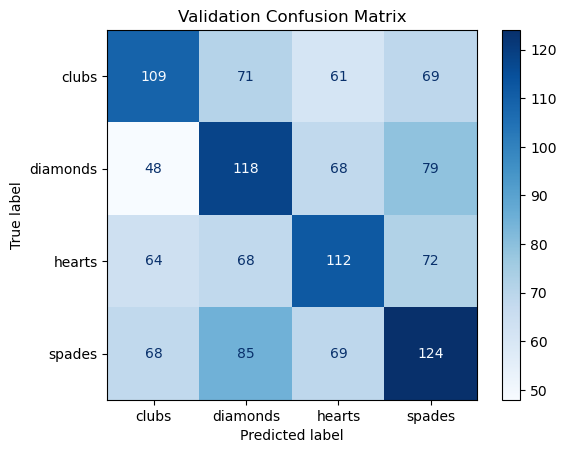

In [20]:
# Calculating the average accuracy for validation dataset
lda_valid_score = lda_best_params.score(flattened_validation_images, encoded_valid_labels)

# Predicting labels of validation data
lda_valid_predict = lda_best_params.predict(flattened_validation_images)


# ------------------ Accuracy Reporting --------------------

# Print Validation Accuracy Score
print(f'Validation accuracy score: {lda_valid_score:.4f}')


# ----------------- Classification Report ------------------

class_names = ['clubs', 'diamonds', 'hearts', 'spades']

# Calculate classification report for validation set
lda_valid_report = classification_report(encoded_valid_labels, lda_valid_predict, target_names=class_names)
print("Validation Classification Report:\n", lda_valid_report)


# ------------------ Confusion Matrix ----------------------

# Generating the confusion matrix
lda_val_confusion_matrix = confusion_matrix(encoded_valid_labels, lda_valid_predict)

# Displaying the confustion matrix
lda_val_display_matrix = ConfusionMatrixDisplay(confusion_matrix = lda_val_confusion_matrix,
                                            display_labels = class_names)

# Display Confusion Matrix
lda_val_display_matrix.plot(cmap=plt.cm.Blues)
lda_val_display_matrix.ax_.set_title('Validation Confusion Matrix')
plt.show()


### 2.4 Scoring and Analysis of Test Dataset using LDA Classifier

Test accuracy score: 0.3101
Test Classification Report:
               precision    recall  f1-score   support

       clubs       0.29      0.28      0.28       387
    diamonds       0.32      0.33      0.32       392
      hearts       0.31      0.32      0.31       395
      spades       0.33      0.31      0.32       432

    accuracy                           0.31      1606
   macro avg       0.31      0.31      0.31      1606
weighted avg       0.31      0.31      0.31      1606



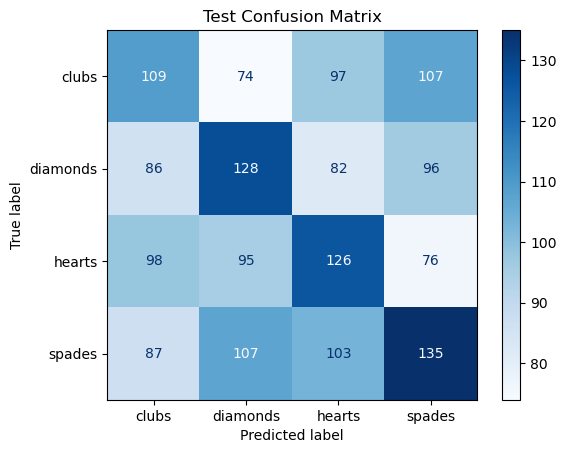

In [21]:
# Calculating the average accuracy score for the test dataset
lda_test_score = lda_best_params.score(flattened_test_images, encoded_test_labels)

# Predicting labels of test data
lda_test_predict = lda_best_params.predict(flattened_test_images)


# ------------------ Accuracy Reporting --------------------

# Print Test Accuracy Score
print(f'Test accuracy score: {lda_test_score:.4f}')


# ----------------- Classification Report ------------------

# Get the class names from the generator (assuming it has the 'class_indices' attribute)

# Calculate classification report for test set
lda_test_report = classification_report(encoded_test_labels, lda_test_predict, target_names = class_names)
print("Test Classification Report:\n", lda_test_report)


# ------------------ Confusion Matrix ----------------------

# Generating the confusion matrix
lda_test_confusion_matrix = confusion_matrix(encoded_test_labels, lda_test_predict)

# Displaying the confustion matrix
lda_test_display_matrix = ConfusionMatrixDisplay(confusion_matrix = lda_test_confusion_matrix,
                                             display_labels = class_names)
# Display Confusion Matrix
lda_test_display_matrix.plot(cmap = plt.cm.Blues)
lda_test_display_matrix.ax_.set_title('Test Confusion Matrix')
plt.show()


## 3. Logistic Regression on Keypoint Features and Descriptors

### 3.1 Hyperparameter tuning of the LR

In [22]:
# HyperParameter Tuning

lr_param_grid = {'lr__penalty': ['l2', None], 
                 'lr__tol': [1e-1, 1e-2, 1e-3, 1e-4], 
                 'lr__C': [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0]} 

lr_pipe = Pipeline([
    ('standardscaler', StandardScaler()),
    ('lr', LogisticRegression())
])

lr_grid_search = GridSearchCV(lr_pipe, lr_param_grid, cv = 5)
lr_grid_search.fit(flattened_train_images, encoded_train_labels)

print("Best parameter (CV score=%0.3f):" % lr_grid_search.best_score_)
print(lr_grid_search.best_params_)

Best parameter (CV score=0.451):
{'lr__C': 1.0, 'lr__penalty': 'l2', 'lr__tol': 0.1}


### 3.2 Selecting the Best Estimater Hyperparamaters for LR

In [23]:
lr_best_params = lr_grid_search.best_estimator_

### 3.3 Scoring and Analysis of Validation Dataset using LR Classifier

Validation accuracy score: 0.3603
Validation Classification Report:
               precision    recall  f1-score   support

       clubs       0.38      0.35      0.36       310
    diamonds       0.35      0.38      0.36       313
      hearts       0.36      0.35      0.36       316
      spades       0.36      0.36      0.36       346

    accuracy                           0.36      1285
   macro avg       0.36      0.36      0.36      1285
weighted avg       0.36      0.36      0.36      1285



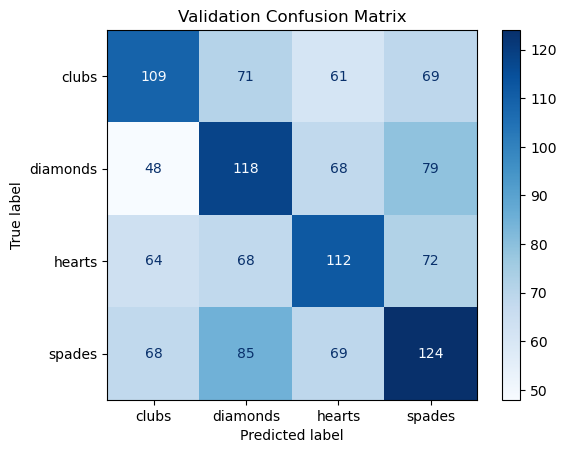

In [24]:
# Calculating the average accuracy for validation dataset
lr_valid_score = lda_best_params.score(flattened_validation_images, encoded_valid_labels)

# Predicting labels of validation data
lr_valid_predict = lda_best_params.predict(flattened_validation_images)


# ------------------ Accuracy Reporting --------------------

# Print Validation Accuracy Score
print(f'Validation accuracy score: {lr_valid_score:.4f}')


# ----------------- Classification Report ------------------

class_names = ['clubs', 'diamonds', 'hearts', 'spades']

# Calculate classification report for validation set
lr_valid_report = classification_report(encoded_valid_labels, lr_valid_predict, target_names=class_names)
print("Validation Classification Report:\n", lr_valid_report)


# ------------------ Confusion Matrix ----------------------

# Generating the confusion matrix
lr_val_confusion_matrix = confusion_matrix(encoded_valid_labels, lr_valid_predict)

# Displaying the confustion matrix
lr_val_display_matrix = ConfusionMatrixDisplay(confusion_matrix = lr_val_confusion_matrix,
                                            display_labels = class_names)

# Display Confusion Matrix
lr_val_display_matrix.plot(cmap=plt.cm.Blues)
lr_val_display_matrix.ax_.set_title('Validation Confusion Matrix')
plt.show()


### 3.4 Scoring and Analysis of Test Dataset using LR Classifier

Test accuracy score: 0.3101
Test Classification Report:
               precision    recall  f1-score   support

       clubs       0.29      0.28      0.28       387
    diamonds       0.32      0.33      0.32       392
      hearts       0.31      0.32      0.31       395
      spades       0.33      0.31      0.32       432

    accuracy                           0.31      1606
   macro avg       0.31      0.31      0.31      1606
weighted avg       0.31      0.31      0.31      1606



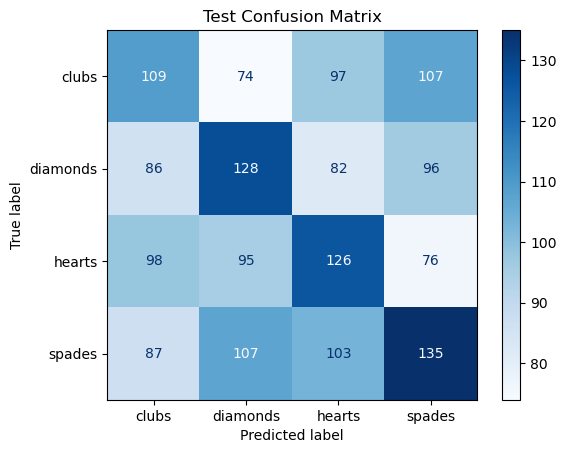

In [25]:
# Calculating the average accuracy score for the test dataset
lr_test_score = lda_best_params.score(flattened_test_images, encoded_test_labels)

# Predicting labels of test data
lr_test_predict = lda_best_params.predict(flattened_test_images)


# ------------------ Accuracy Reporting --------------------

# Print Test Accuracy Score
print(f'Test accuracy score: {lr_test_score:.4f}')


# ----------------- Classification Report ------------------

# Get the class names from the generator (assuming it has the 'class_indices' attribute)

# Calculate classification report for test set
lr_test_report = classification_report(encoded_test_labels, lr_test_predict, target_names = class_names)
print("Test Classification Report:\n", lr_test_report)


# ------------------ Confusion Matrix ----------------------

# Generating the confusion matrix
lr_test_confusion_matrix = confusion_matrix(encoded_test_labels, lr_test_predict)

# Displaying the confustion matrix
lr_test_display_matrix = ConfusionMatrixDisplay(confusion_matrix = lda_test_confusion_matrix,
                                             display_labels = class_names)
# Display Confusion Matrix
lr_test_display_matrix.plot(cmap = plt.cm.Blues)
lr_test_display_matrix.ax_.set_title('Test Confusion Matrix')
plt.show()


## 4. Random Forest on Keypoint Features and Descriptors

### 4.1 Hyperparameter Tuning of the Random Forest

In [26]:
# Define the parameter distributions for Random Search
rf_param_dist = {
    'n_estimators': randint(100, 1000),  # Number of trees in the forest
    'max_depth': [None] + list(range(10, 110, 10)),  # Maximum depth of the tree
    'min_samples_split': randint(2, 11),  
    'min_samples_leaf': randint(1, 11) 
}

# Initialize the Random Forest classifier
rf_classifier = RandomForestClassifier(random_state=42)

# Create a RandomizedSearchCV object
rf_random_search = RandomizedSearchCV(rf_classifier, param_distributions=rf_param_dist, n_iter=10, cv=3, n_jobs=-1)

# Train the Random Search on train_hog_features and train_labels
rf_random_search.fit(flattened_train_images, encoded_train_labels)

# Print the best hyperparameters found by Random Search
print('Best hyperparameters:', rf_random_search.best_params_)

Best hyperparameters: {'max_depth': 90, 'min_samples_leaf': 9, 'min_samples_split': 3, 'n_estimators': 934}


### 4.2 Selecting the Best Hyperparameters for the Random Forest classifier

In [27]:
# Get the best Random Forest classifier
rf_best_params = rf_random_search.best_estimator_

### 4.3 Scoring and Analysis of Validation Dataset using Random Forest Classifier

Validation accuracy score: 0.5346
Validation Classification Report:
               precision    recall  f1-score   support

       clubs       0.59      0.45      0.51       310
    diamonds       0.49      0.64      0.55       313
      hearts       0.54      0.50      0.52       316
      spades       0.55      0.55      0.55       346

    accuracy                           0.53      1285
   macro avg       0.54      0.53      0.53      1285
weighted avg       0.54      0.53      0.53      1285



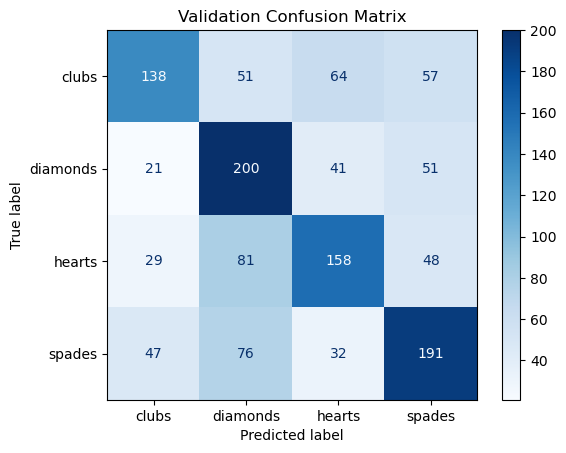

In [28]:
# Calculating the average accuracy for validation dataset
rf_valid_score = rf_best_params.score(flattened_validation_images, encoded_valid_labels)

# Predicting labels of validation data
rf_valid_predict = rf_best_params.predict(flattened_validation_images)


# ------------------ Accuracy Reporting --------------------

# Print Validation Accuracy Score
print(f'Validation accuracy score: {rf_valid_score:.4f}')


# ----------------- Classification Report ------------------

class_names = ['clubs', 'diamonds', 'hearts', 'spades']

# Calculate classification report for validation set
rf_valid_report = classification_report(encoded_valid_labels, rf_valid_predict, target_names=class_names)
print("Validation Classification Report:\n", rf_valid_report)


# ------------------ Confusion Matrix ----------------------

# Generating the confusion matrix
rf_val_confusion_matrix = confusion_matrix(encoded_valid_labels, rf_valid_predict)

# Displaying the confustion matrix
rf_val_display_matrix = ConfusionMatrixDisplay(confusion_matrix = rf_val_confusion_matrix,
                                            display_labels = class_names)

# Display Confusion Matrix
rf_val_display_matrix.plot(cmap=plt.cm.Blues)
rf_val_display_matrix.ax_.set_title('Validation Confusion Matrix')
plt.show()


### 4.4 Scoring and Analysis of Validation Dataset using Random Forest Classifier

Test accuracy score: 0.5311
Test Classification Report:
               precision    recall  f1-score   support

       clubs       0.57      0.47      0.51       387
    diamonds       0.47      0.65      0.55       392
      hearts       0.57      0.49      0.52       395
      spades       0.55      0.52      0.53       432

    accuracy                           0.53      1606
   macro avg       0.54      0.53      0.53      1606
weighted avg       0.54      0.53      0.53      1606



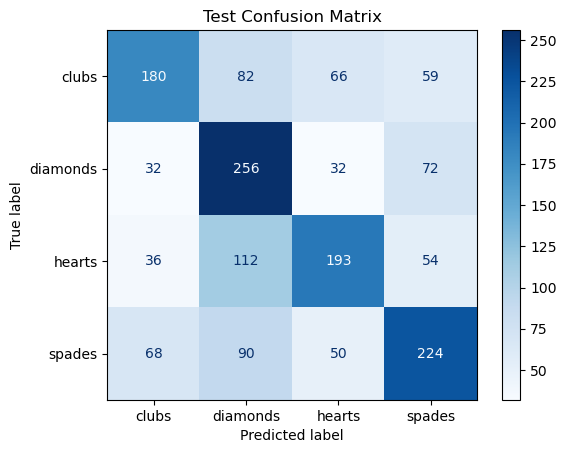

In [29]:
# Calculating the average accuracy score for the test dataset
rf_test_score = rf_best_params.score(flattened_test_images, encoded_test_labels)

# Predicting labels of test data
rf_test_predict = rf_best_params.predict(flattened_test_images)


# ------------------ Accuracy Reporting --------------------

# Print Test Accuracy Score
print(f'Test accuracy score: {rf_test_score:.4f}')


# ----------------- Classification Report ------------------

# Get the class names from the generator (assuming it has the 'class_indices' attribute)

# Calculate classification report for test set
rf_test_report = classification_report(encoded_test_labels, rf_test_predict, target_names = class_names)
print("Test Classification Report:\n", rf_test_report)


# ------------------ Confusion Matrix ----------------------

# Generating the confusion matrix
rf_test_confusion_matrix = confusion_matrix(encoded_test_labels, rf_test_predict)

# Displaying the confustion matrix
rf_test_display_matrix = ConfusionMatrixDisplay(confusion_matrix = rf_test_confusion_matrix,
                                             display_labels = class_names)
# Display Confusion Matrix
rf_test_display_matrix.plot(cmap = plt.cm.Blues)
rf_test_display_matrix.ax_.set_title('Test Confusion Matrix')
plt.show()


## 5 Neural Network on on Keypoint Features and Descriptors

In [30]:
# CNN using the train Keypoint features
def cnn_model(hp):
    model = Sequential()
    model.add(Dense(units=hp.Int('units', min_value=8, max_value=64, step=8), 
                    activation='relu', 
                    input_shape=(flattened_train_images.shape[1],))
             )
    
    model.add(Dense(4, activation='softmax'))

    model.compile(optimizer=Adam(learning_rate=hp.Choice('learning_rate', values=[1e-4, 1e-5, 1e-6])), 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy']
                 )

    return model

In [31]:
# Convert labels to arrays and one-hot encode
train_cat_labels = to_categorical(encoded_train_labels, num_classes=4)
valid_cat_labels = to_categorical(encoded_valid_labels, num_classes=4)
test_cat_labels = to_categorical(encoded_test_labels, num_classes=4)

In [32]:
# Hyperparameter Search
def hyperparameter_search(train_data, train_labels, valid_data, valid_labels):
    tuner = kt.RandomSearch(
        cnn_model,
        objective='val_accuracy',
        max_trials=50,  # Number of hyperparameter combinations to try
        directory='hyperparameter_search',
        project_name='hog_classifier',
        overwrite=True
    )
    stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)

    # Perform the hyperparameter search
    tuner.search(train_data, 
                 train_labels, 
                 epochs = 10, 
                 validation_data=(valid_data, valid_labels), 
                 callbacks=[stop_early]
                )

    # Get the best hyperparameters
    best_hps = tuner.get_best_hyperparameters(num_trials = 1)[0]

    return best_hps

In [33]:
num_classes = 4

# Perform hyperparameter search
best_hyperparameters = hyperparameter_search(flattened_train_images, 
                                             train_cat_labels, 
                                             flattened_validation_images, 
                                             valid_cat_labels
                                            )
print("Best hyperparameters:")
print(best_hyperparameters)

Trial 23 Complete [00h 00m 22s]
val_accuracy: 0.5097275972366333

Best val_accuracy So Far: 0.5159533023834229
Total elapsed time: 00h 07m 45s
INFO:tensorflow:Oracle triggered exit


INFO:tensorflow:Oracle triggered exit


Best hyperparameters:


In [34]:
# Train the model with the best hyperparameters
final_cnn_model = cnn_model(best_hyperparameters)
history = final_cnn_model.fit(flattened_train_images, 
                              train_cat_labels, 
                              epochs=5, 
                              batch_size=32, 
                              validation_data=(flattened_validation_images, valid_cat_labels))

Epoch 1/5
  6/161 [>.............................] - ETA: 1s - loss: 1.4111 - accuracy: 0.2865 

2023-08-05 06:00:54.104576: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


161/161 [==============================] - ETA: 0s - loss: 1.3297 - accuracy: 0.3480

2023-08-05 06:00:56.014233: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


161/161 [==============================] - 2s 14ms/step - loss: 1.3297 - accuracy: 0.3480 - val_loss: 1.2723 - val_accuracy: 0.4171
Epoch 2/5
161/161 [==============================] - 2s 12ms/step - loss: 1.2046 - accuracy: 0.4718 - val_loss: 1.2106 - val_accuracy: 0.4794
Epoch 3/5
161/161 [==============================] - 2s 12ms/step - loss: 1.1176 - accuracy: 0.5368 - val_loss: 1.1809 - val_accuracy: 0.4864
Epoch 4/5
161/161 [==============================] - 2s 12ms/step - loss: 1.0504 - accuracy: 0.5802 - val_loss: 1.1559 - val_accuracy: 0.4981
Epoch 5/5
161/161 [==============================] - 2s 12ms/step - loss: 0.9937 - accuracy: 0.6139 - val_loss: 1.1597 - val_accuracy: 0.5074


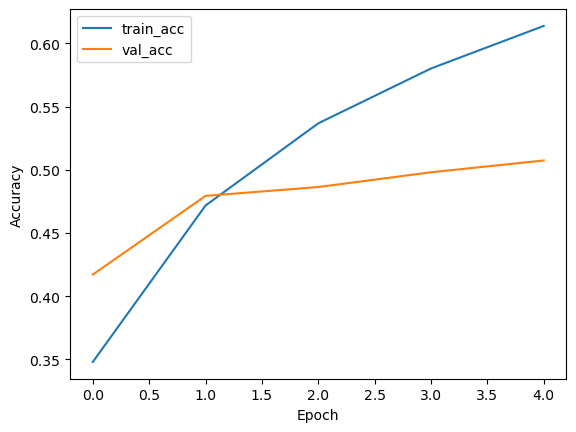

In [35]:
# Plot accuracy
plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

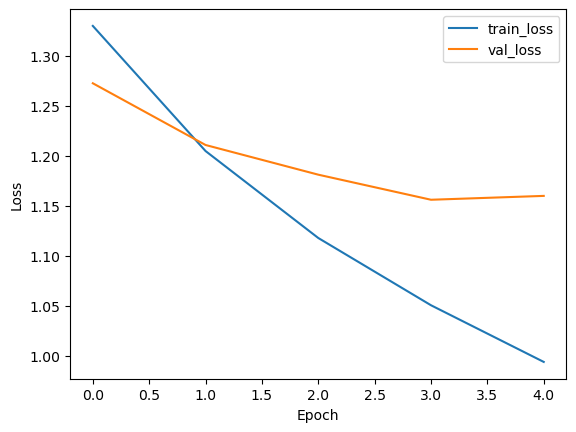

In [36]:
#Plot Loss
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

41/41 [==============================] - 0s 3ms/step


2023-08-05 06:01:04.585307: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Validation Accuracy: 0.5074
Validation Classification Report:
               precision    recall  f1-score   support

       clubs       0.45      0.57      0.50       310
    diamonds       0.63      0.43      0.51       313
      hearts       0.47      0.62      0.54       316
      spades       0.55      0.42      0.48       346

    accuracy                           0.51      1285
   macro avg       0.52      0.51      0.51      1285
weighted avg       0.53      0.51      0.51      1285



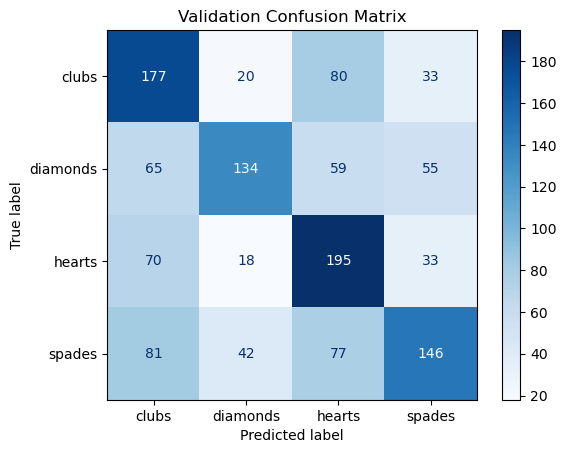

In [37]:
# Make predictions on the validation set
valid_predictions_probs = final_cnn_model.predict(flattened_validation_images)
valid_predictions = np.argmax(valid_predictions_probs, axis=1)
valid_accuracy = accuracy_score(encoded_valid_labels, valid_predictions) # Calculate validation accuracy
print(f'Validation Accuracy: {valid_accuracy:.4f}')

# Get the class names from the generator (assuming it has the 'class_indices' attribute)
class_names = ['clubs', 'diamonds', 'hearts', 'spades']

# Calculate classification report for validation set
valid_report = classification_report(encoded_valid_labels, valid_predictions, target_names=class_names)
print("Validation Classification Report:\n", valid_report)

# Generating the confusion matrix validation dataset
val_confusion_matrix = confusion_matrix(encoded_valid_labels, valid_predictions)

# Displaying the confustion matrix
val_display_matrix = ConfusionMatrixDisplay(confusion_matrix = val_confusion_matrix,
                                            display_labels = class_names)

# Display Confusion Matrix
val_display_matrix.plot(cmap=plt.cm.Blues)
val_display_matrix.ax_.set_title('Validation Confusion Matrix')
plt.show()

51/51 [==============================] - 0s 3ms/step
Test Accuracy: 0.4795
Test Classification Report:
               precision    recall  f1-score   support

       clubs       0.43      0.55      0.48       387
    diamonds       0.57      0.37      0.45       392
      hearts       0.45      0.63      0.52       395
      spades       0.55      0.39      0.45       432

    accuracy                           0.48      1606
   macro avg       0.50      0.48      0.48      1606
weighted avg       0.50      0.48      0.47      1606



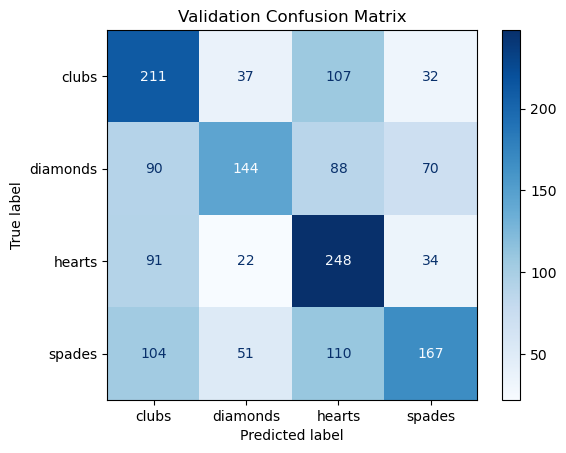

In [38]:
# Make predictions on the test set
test_predictions_probs = final_cnn_model.predict(flattened_test_images)
test_predictions = np.argmax(test_predictions_probs, axis=1)
test_accuracy = accuracy_score(encoded_test_labels, test_predictions) # Calculate test accuracy
print(f'Test Accuracy: {test_accuracy:.4f}')

# Calculate classification report for test set
test_report = classification_report(encoded_test_labels, test_predictions, target_names=class_names)
print("Test Classification Report:\n", test_report)

# Generating the confusion matrix for test dataset
test_confusion_matrix = confusion_matrix(encoded_test_labels, test_predictions)

# Displaying the confustion matrix
test_display_matrix = ConfusionMatrixDisplay(confusion_matrix = test_confusion_matrix,
                                             display_labels = class_names)

# Display Confusion Matrix
test_display_matrix.plot(cmap=plt.cm.Blues)
test_display_matrix.ax_.set_title('Validation Confusion Matrix')
plt.show()